In [5]:
# !pip install torch==2.2
!pip install torchvision==0.17 # even I dont install torch 2.2 this will uninstall current 
!pip install nltk==3.7         # and install what torch it needs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 3.6 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.8 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.6 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.3 MB/s eta 0:00:000m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 20.5 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.9 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 24.0 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.6 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━

In [1]:
import torch

In [3]:
print(torch.__version__)

2.1.2


In [5]:
torch.cuda.is_available()

True

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

torch.use_deterministic_algorithms(True)

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.cn1 = nn.Conv2d(3, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, (2, 2))
        
        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, (2, 2))

        x = x.view(-1, self.flattened_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def flattened_features(self, x):
        size = x.size()[1:]
        num_feats = 1

        for s in size:
            num_feats *= s

        return num_feats

lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
def train(net, trainloader, optim, epoch):
    loss_total = 0.0

    for i, data in enumerate(trainloader, 0):
        ip, ground_truth = data
        
        optim.zero_grad()
        
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()
        
        loss_total += loss.item()

        if (i+1) % 1000 == 0:
            print('[Epoch number: %d, Mini-batches: %d] loss: %.3f' % (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

In [4]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 1000 image from test dataset: %d %%' % (100 * success / counter))

In [6]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='/home/antirrabia/Documents/speriments/torch_datasets/',
    train=True,
    download=True,
    transform=train_transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=8,
    shuffle=True
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

testset = torchvision.datasets.CIFAR10(
    root='/home/antirrabia/Documents/speriments/torch_datasets/',
    train=False,
    download=True,
    transform=test_transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1000,
    shuffle=True
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


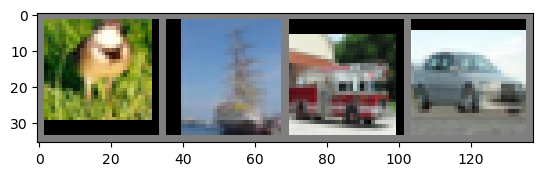

       bird    ||    ship    ||    truck    ||    car


In [7]:
def imageshow(image):
    image = image/2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 4
imageshow(torchvision.utils.make_grid(images[: num_images]))

print('       ' + '    ||    '.join(classes[labels[j]] for j in range(num_images)))

In [10]:
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

for epoch in range(50):
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number: 1, Mini-batches: 1000] loss: 10.080
[Epoch number: 1, Mini-batches: 2000] loss: 8.956
[Epoch number: 1, Mini-batches: 3000] loss: 8.429
[Epoch number: 1, Mini-batches: 4000] loss: 8.066
[Epoch number: 1, Mini-batches: 5000] loss: 7.905
[Epoch number: 1, Mini-batches: 6000] loss: 7.713

LeNet accuracy on 1000 image from test dataset: 45 %

[Epoch number: 2, Mini-batches: 1000] loss: 7.498
[Epoch number: 2, Mini-batches: 2000] loss: 7.310
[Epoch number: 2, Mini-batches: 3000] loss: 7.175
[Epoch number: 2, Mini-batches: 4000] loss: 7.208
[Epoch number: 2, Mini-batches: 5000] loss: 7.098
[Epoch number: 2, Mini-batches: 6000] loss: 7.039

LeNet accuracy on 1000 image from test dataset: 51 %

[Epoch number: 3, Mini-batches: 1000] loss: 6.857
[Epoch number: 3, Mini-batches: 2000] loss: 6.821
[Epoch number: 3, Mini-batches: 3000] loss: 6.699
[Epoch number: 3, Mini-batches: 4000] loss: 6.785
[Epoch number: 3, Mini-batches: 5000] loss: 6.660
[Epoch number: 3, Mini-batches: 6000] l

In [12]:
model_path = '/home/antirrabia/Documents/speriments/torch_models/lenet_cifar10.pth'
torch.save(lenet.state_dict(), model_path)

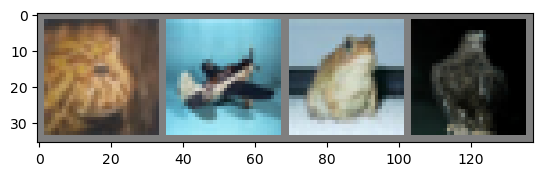

Label:         frog plane  frog  bird
Prediction:   frog plane   cat  frog


In [13]:
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:       ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

op = lenet_cached(im)

_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [14]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 1000 images from test dataset: %d %%' % (100 * success / counter))

Model accuracy on 1000 images from test dataset: 64 %


In [16]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(1000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 61 %
Model accuracy for class   car : 86 %
Model accuracy for class  bird : 42 %
Model accuracy for class   cat : 63 %
Model accuracy for class  deer : 65 %
Model accuracy for class   dog : 31 %
Model accuracy for class  frog : 88 %
Model accuracy for class horse : 64 %
Model accuracy for class  ship : 72 %
Model accuracy for class truck : 73 %
